# 5. Claim Frequency and Severity Modelling

Usually, Poisson GLM is used to model claim frequency. We now investigate the possibility to use decision trees to model claim counts using a Poisson loss function.

Description of ```tree.DecisionTreeRegressor``` parametrization:
* criterion: the function to measure the quality of a split.
* splitter: the strategy used to choose the split at each node. 
* max_depth: the maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
* min_samples_split (default =2): minimum number of samples required to split an internal node.
* min_samples_leaf (default =1): The minimum number of samples required to be at a leaf node.
* min_weight_fraction_leaf (default =0.0): The minimum weighted fraction of the sum total of weights (of all the input samples) required to be at a leaf node.
* max_features(default =None, but auto is valid choice): The number of features to consider when looking for the best split.
* ccp_alpha: Complexity parameter used for Minimal Cost-Complexity Pruning

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os

In [10]:
df = pd.read_csv(r'.\data\PC_data.txt', sep = '\s+')
df.columns = map(str.lower, df.columns)
df = df.drop('id', axis = 1)
df.head()

,nclaims,amount,avg,exp,coverage,fuel,use,fleet,sex,ageph,bm,agec,power,pc,town,long,lat
0,1,1618.001036,1618.001036,1.000000,TPL,gasoline,private,N,male,50,5,12,77,1000,BRUSSEL,4.355223,50.845386
1,0,0.000000,NaN,1.000000,PO,gasoline,private,N,female,64,5,3,66,1000,BRUSSEL,4.355223,50.845386
2,0,0.000000,NaN,1.000000,TPL,diesel,private,N,male,60,0,10,70,1000,BRUSSEL,4.355223,50.845386
3,0,0.000000,NaN,1.000000,TPL,gasoline,private,N,male,77,0,15,57,1000,BRUSSEL,4.355223,50.845386
4,1,155.974606,155.974606,0.046575,TPL,gasoline,private,N,female,28,9,7,70,1000,BRUSSEL,4.355223,50.845386


In [11]:
# converting type(str) columns to categorical
df['coverage'] = df['coverage'].astype('category').cat.codes
df['fleet'] = df['fleet'].astype('category').cat.codes
df['sex'] = df['sex'].astype('category').cat.codes
df['town'] = df['town'].astype('category').cat.codes
df['fuel'] = df['fuel'].astype('category').cat.codes
df['use'] = df['use'].astype('category').cat.codes

In [12]:
exp = df['exp']
y = np.array(df['nclaims']/df['exp'])
x = np.array(df[['bm','ageph','agec','power','coverage','fuel','sex','fleet','use']])
col_names = ['ageph','agec','bm','power','coverage','fuel','sex','fleet','use']

Since there is no convenient way to implement the exposure in the Poisson regression tree. Therefore, we divide the response by the exposure and we fit regression tree minimizing MSE and setting weights = exposure term.

In [5]:
from sklearn import metrics
from sklearn import tree

In [6]:
rgf_dt = tree.DecisionTreeRegressor(criterion="mse", max_depth = 3,
                                      min_samples_split = 10,
                                      min_samples_leaf = 10,
                                      ccp_alpha = 0, splitter="best").fit(x,y,exp)

We can provide a stylized representation of the Regression Tree via ```export_text()``` built-in method:

In [7]:
text_representation = tree.export_text(rgf_dt, feature_names = col_names)
print(text_representation)

|--- ageph <= 6.50
|   |--- ageph <= 1.50
|   |   |--- agec <= 55.50
|   |   |   |--- value: [0.12]
|   |   |--- agec >  55.50
|   |   |   |--- value: [0.09]
|   |--- ageph >  1.50
|   |   |--- agec <= 57.50
|   |   |   |--- value: [0.15]
|   |   |--- agec >  57.50
|   |   |   |--- value: [0.12]
|--- ageph >  6.50
|   |--- ageph <= 10.50
|   |   |--- agec <= 26.50
|   |   |   |--- value: [0.24]
|   |   |--- agec >  26.50
|   |   |   |--- value: [0.19]
|   |--- ageph >  10.50
|   |   |--- bm <= 6.50
|   |   |   |--- value: [0.23]
|   |   |--- bm >  6.50
|   |   |   |--- value: [0.29]



We can provide a graphic representation of the Regression Tree via ```plot_treet()``` built-in method:

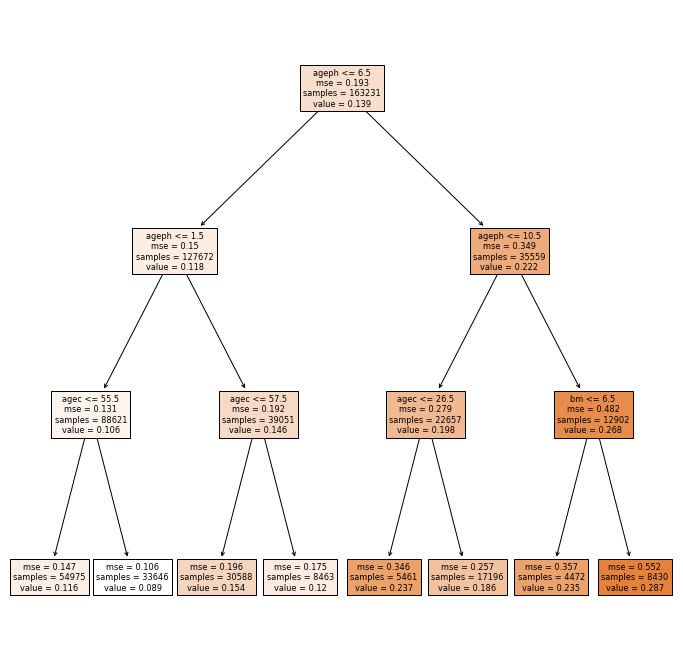

In [8]:
%matplotlib inline
plt.figure(figsize=(12,12))
_ = tree.plot_tree(rgf_dt, 
                   feature_names = col_names,
                   filled = True)

It is possible to retrieve all samples the fell into the nodes. In order to do so, we implement a custom function to provide a new stylized representation of the Regression Tree retaining more information and non-rounded leaf values:

In [837]:
n_nodes = rgf_dt.tree_.node_count
children_left = rgf_dt.tree_.children_left
children_right = rgf_dt.tree_.children_right
feature = rgf_dt.tree_.feature
threshold = rgf_dt.tree_.threshold
value = rgf_dt.tree_.value

# The tree structure can be traversed to compute various properties such
# as the depth of each node and whether or not it is a leaf.
node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
is_leaves = np.zeros(shape=n_nodes, dtype=bool)
stack = [(0, -1)]  # seed is the root node id and its parent depth
while len(stack) > 0:
    node_id, parent_depth = stack.pop()
    node_depth[node_id] = parent_depth + 1

    # If we have a test node
    if (children_left[node_id] != children_right[node_id]):
        stack.append((children_left[node_id], parent_depth + 1))
        stack.append((children_right[node_id], parent_depth + 1))
    else:
        is_leaves[node_id] = True


print("The binary tree structure has %s nodes and has "
      "the following tree structure:"
      % n_nodes)
for i in range(n_nodes):
    if is_leaves[i]:
        print("%s*node=%s leaf node. Value here is: %s" % (node_depth[i] * "\t", i, value[i]))
    else:
        print("%snode=%s test node: go to node %s if X[:, %s] <= %s else to "
              "node %s."
              % (node_depth[i] * "\t",
                 i,
                 children_left[i],
                 feature[i],
                 threshold[i],
                 children_right[i],
                 ))

The binary tree structure has 7 nodes and has the following tree structure:
node=0 test node: go to node 1 if X[:, 0] <= 18.5 else to node 2.
	*node=1 leaf node. Value here is: [[1.08180202]]
	node=2 test node: go to node 3 if X[:, 1] <= 32.5 else to node 6.
		node=3 test node: go to node 4 if X[:, 0] <= 91.5 else to node 5.
			*node=4 leaf node. Value here is: [[0.13938908]]
			*node=5 leaf node. Value here is: [[0.05205362]]
		*node=6 leaf node. Value here is: [[0.01212021]]


We subset the dataset to verify whether the prediction in a leaf node is what you would expect:
* take the node ```bm <= 1.5``` and ```ageph > 55.50```  
* Calculate the expected claim frequency as ```sum(nclaims)/sum(expo)```
* Compare it with the correspondent leaf prediction

In [680]:
# subsetting the dataset
sub_df = df.loc[(df.bm<=1.5)&(df.ageph>55.50)]

In [681]:
# calculate the expected claim frequency (rounding by 8)
exp_cf = np.round(np.sum(sub_df.nclaims)/np.sum(sub_df.exp),8)

In [682]:
# compare the expected claim frequency and the predicted claim frequency in the leaf
print(f'Expected claim frequency: {exp_cf}, Predicted claim frequency in leaf: {np.round(float(rgf_dt.tree_.value[4]),8)}')

Expected claim frequency: 0.08898655, Predicted claim frequency in leaf: 0.08898655


### 5.1 Pruning Trees with cost complexity

The DecisionTreeClassifier provides parameters such as ```min_samples_leaf``` and ```max_depth``` to prevent a tree from overfiting. Cost complexity pruning provides another option to control the size of a tree.

this pruning technique is parameterized by the cost complexity parameter, ```ccp_alpha```. Greater values of ```ccp_alpha``` increase the number of nodes pruned. Here we only show the effect of ccp_alpha on regularizing the trees and how to choose a ccp_alpha based on validation scores.

Minimal cost complexity pruning recursively finds the node with the “weakest link”. The weakest link is characterized by an effective alpha, where the nodes with the smallest effective alpha are pruned first. To get an idea of what values of ```ccp_alpha``` could be appropriate, scikit-learn provides ```DecisionTreeRegressor.cost_complexity_pruning_path``` that returns the effective alphas and the corresponding total leaf impurities at each step of the pruning process. As alpha increases, more of the tree is pruned, which increases the total impurity of its leaves.

In [817]:
path = rgf_dt.cost_complexity_pruning_path(x, y, exp)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

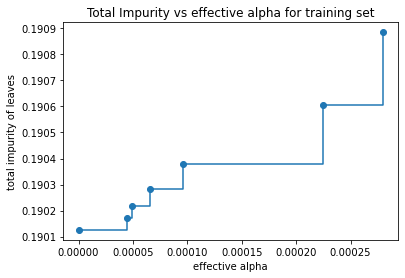

In [818]:
%matplotlib inline
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

We train a decision tree using the effective alphas.

In [819]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = tree.DecisionTreeRegressor(criterion="mse", max_depth = 30,
                                      min_samples_split = 2000,
                                      min_samples_leaf = 1000,
                                      ccp_alpha = ccp_alpha, splitter="best").fit(x,y,exp)
    clfs.append(clf)

In [808]:
print(f"Number of nodes in the last tree is: {clfs[-1].tree_.node_count} with ccp_alpha: {ccp_alphas[-1]}")

Number of nodes in the last tree is: 7 with ccp_alpha: 0.0002247868330777364


We remove the last element in clfs and ccp_alphas, because it is the trivial tree with only one node. Here we show that the number of nodes and tree depth decreases as alpha increases.

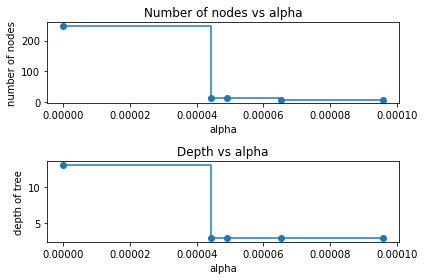

In [809]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]

fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

In [811]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score

alpha_loop_values = []
for ccp_alpha in ccp_alphas:
    regr_dt = tree.DecisionTreeRegressor(criterion="mse", max_depth = 30,
                                      min_samples_split = 2000,
                                      min_samples_leaf = 1000,
                                      ccp_alpha = ccp_alpha, splitter = 'best').fit(x, y, exp)
    
    predictions = regr_dt.predict(x)
    cvs = np.mean(cross_val_score(regr_dt, x, y, cv = 5, scoring='neg_mean_squared_error'))
    node_counts = regr_dt.tree_.node_count
    depth = regr_dt.tree_.max_depth
    
    alpha_loop_values.append([ccp_alpha, node_counts, depth,
                              cvs])

In [812]:
alpha_results = pd.DataFrame(alpha_loop_values, 
                         columns=['alpha', 'node_counts', 'depth','cvs'])

# taking absolute value of cvs
alpha_results['cvs'] = np.abs(alpha_results.cvs)
alpha_results

,alpha,node_counts,depth,cvs
0,0.000000,247,13,0.950788
1,0.000044,13,3,0.950614
2,0.000049,13,3,0.950610
3,0.000065,11,3,0.950628
4,0.000096,9,3,0.950697


In [813]:
alpha_results = alpha_results.loc[(alpha_results['cvs']==np.min(alpha_results['cvs']))]
best_alpha = alpha_results.loc[(alpha_results['depth']==np.max(alpha_results['depth']))]

In [815]:
regr_dt = tree.DecisionTreeRegressor(criterion="mse", max_depth = int(best_alpha.depth),
                                      min_samples_split = 2000,
                                      min_samples_leaf = 1000,
                                      ccp_alpha = float(best_alpha.alpha), splitter = 'best').fit(x, y, exp)
y_deep_tree = regr_dt.predict(x)

In [816]:
text_representation = tree.export_text(regr_dt, feature_names = col_names)
print(text_representation)

|--- bm <= 6.50
|   |--- bm <= 1.50
|   |   |--- ageph <= 55.50
|   |   |   |--- value: [0.12]
|   |   |--- ageph >  55.50
|   |   |   |--- value: [0.09]
|   |--- bm >  1.50
|   |   |--- ageph <= 57.50
|   |   |   |--- value: [0.15]
|   |   |--- ageph >  57.50
|   |   |   |--- value: [0.12]
|--- bm >  6.50
|   |--- bm <= 10.50
|   |   |--- ageph <= 26.50
|   |   |   |--- value: [0.24]
|   |   |--- ageph >  26.50
|   |   |   |--- value: [0.19]
|   |--- bm >  10.50
|   |   |--- value: [0.27]

